In [69]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [70]:
from my_utils import device, set_random_seed, base_path, plot_stats_path, count_model_params, load_model
from my_torch_train import train_epoch, eval_model, train_model

import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [72]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

# Model definition

## VanillaVAE

In [73]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()

In [74]:
class VanillaVAE(nn.Module):
    """
    Implementation of a fully connect variational autoencoder for 
    CIFAR-10 images
    """
    
    def __init__(self, in_size=(3,32,32), sizes=[3072, 128, 10], act="ReLU"):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation = get_act(act) 
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(sizes[-2], sizes[-1])
        self.fc_sigma = nn.Linear(sizes[-2], sizes[-1])
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-2):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append( self.activation )
                
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-1] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        
        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        
        return x_hat, (z, mu, log_var)


## Train VanillaVAE

In [75]:
vanilla_vae = VanillaVAE(sizes=[3072, 384, 256, 192, 64, 2])
vanilla_vae = vanilla_vae.to(device)

In [76]:
# count_model_params(ae)
print(f"Encoder has {count_model_params(vanilla_vae.encoder)} params")
print(f"Decoder has {count_model_params(vanilla_vae.decoder)} params")

Encoder has 1340288 params
Decoder has 1343488 params


In [77]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
#     recons_loss = F.mse_loss(recons, target, reduction="mean")  # if you use this, remove final sigmoid
    b_size = recons.shape[0]
    recons_loss = F.binary_cross_entropy(recons.view(b_size,-1), target.view(b_size,-1), reduction='sum')
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)

In [78]:
savepath = 'imgs/vanilla_vae'
vanilla_vae

VanillaVAE(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=384, bias=True)
    (2): ReLU()
    (3): Linear(in_features=384, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=192, bias=True)
    (6): ReLU()
    (7): Linear(in_features=192, out_features=64, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=192, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=384, bias=True)
    (7): ReLU()
    (8): Linear(in_features=384, out_features=3072, bias=True)
    (9): Sigmoid()
  )
  (fc_mu): Linear(in_features=64, out_features=2, bias=True)
  (fc_sigma): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
optimizer = torch.optim.Adam(vanilla_vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)


In [20]:
%%time
train_loss, val_loss, loss_iters = train_model(
        model=vanilla_vae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20, savepath=savepath, model_path='models/vanilla_vae.pt'
    )

Epoch 0
    Train loss: 2026.3593
    Valid loss: 2129.85139
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
    Train loss: 1957.00124
    Valid loss: 1965.85999
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
    Train loss: 1949.05025
    Valid loss: 1953.8856
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
    Train loss: 1945.28796
    Valid loss: 1947.30984
Epoch 16
Epoch 17
Epoch 18
Epoch 19
    Train loss: 1945.94
    Valid loss: 1944.50081
Training completed
CPU times: user 2min 12s, sys: 631 ms, total: 2min 13s
Wall time: 2min 14s


In [79]:
vanilla_vae, train_loss, val_loss, loss_iters = load_model('models/vanilla_vae.pt')

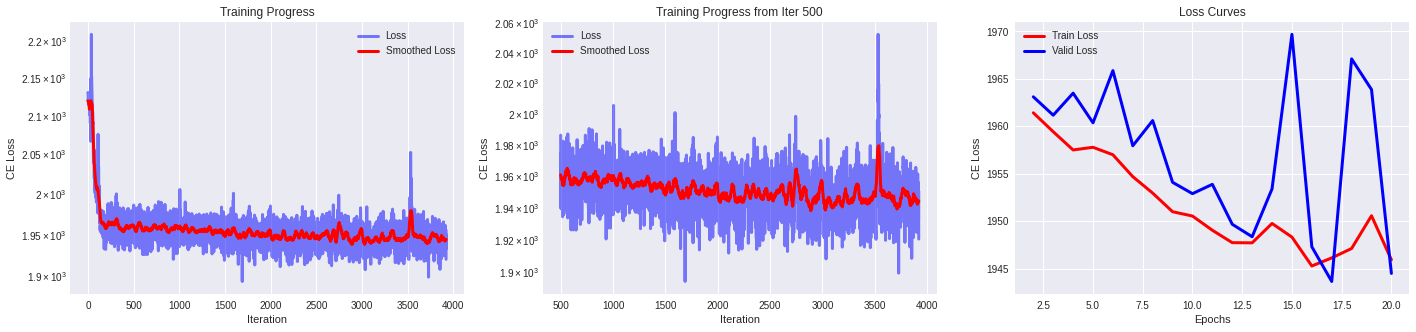

In [80]:
plot_stats_path('models/vanilla_vae.pt')

The training plot (especially the validation loss) looks rather weird.
Also, the loss drops in the beginning but then does not drop that much.

This is maybe due to the fact that such a fully connected model is not that well suited for this task.

Also its hard to really learn distributions for CIFAR-10 images, since they are rather diverse.

## Some Analysis

In [81]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [85]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")
    
    
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = vanilla_vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)
            
def display_model(mode, imgs_flat, latents, labels, N=1000, perplexity=30.0):
    # mode can either be pca or tsne
    assert mode in ['pca', 'tsne']

    if mode == 'pca':
        embd_imgs = PCA(n_components=2).fit_transform(imgs_flat)
        embd_latents = PCA(n_components=2).fit_transform(latents)
    else:
        embd_imgs = TSNE(n_components=2, perplexity=perplexity).fit_transform(imgs_flat[:N])
        embd_latents = TSNE(n_components=2, perplexity=perplexity).fit_transform(latents[:N])
        
    fig,ax = plt.subplots(1,2,figsize=(26,8))
    display_projections(embd_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
    ax[0].set_title(mode+" Proj. of Images")
    display_projections(embd_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
    ax[1].set_title(mode+" Proj. of Encoded Representations")
    plt.show()

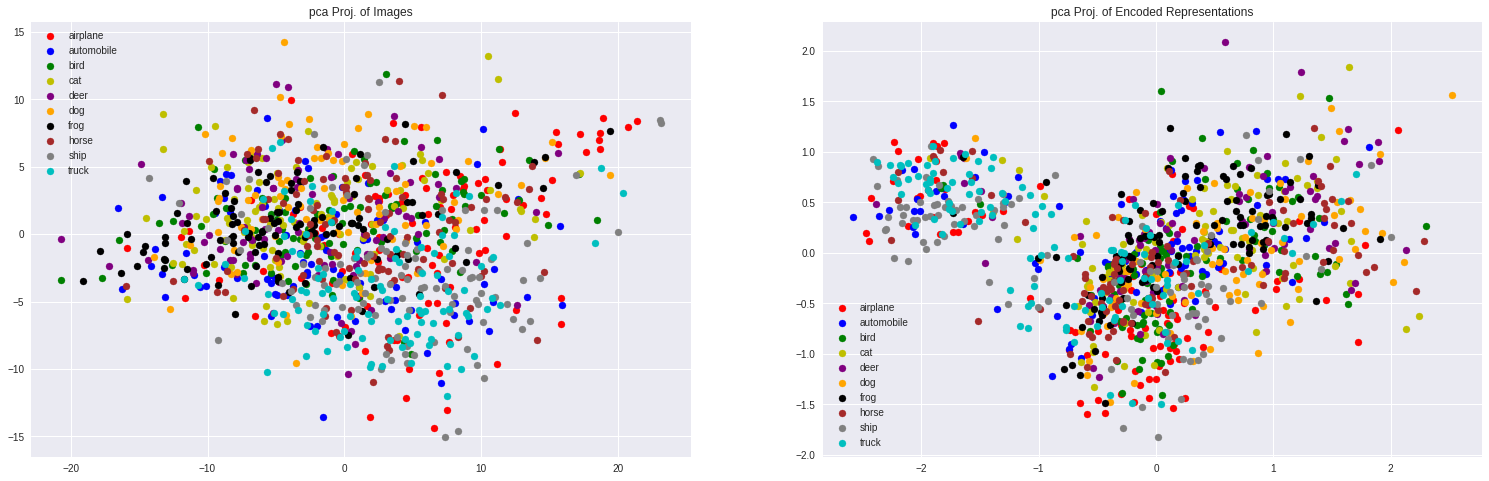

In [83]:
display_model('pca', imgs_flat, latents, labels)

In the PCA-projection of the encoded representations there seem to be two clusters.
One cluster seems to be mixed up and the other one seems to contain especially ships, trucks and airplanes.

Interestingly, in the pca projection of the images, the trucks seem to be the class that could best be separated form the other ones.

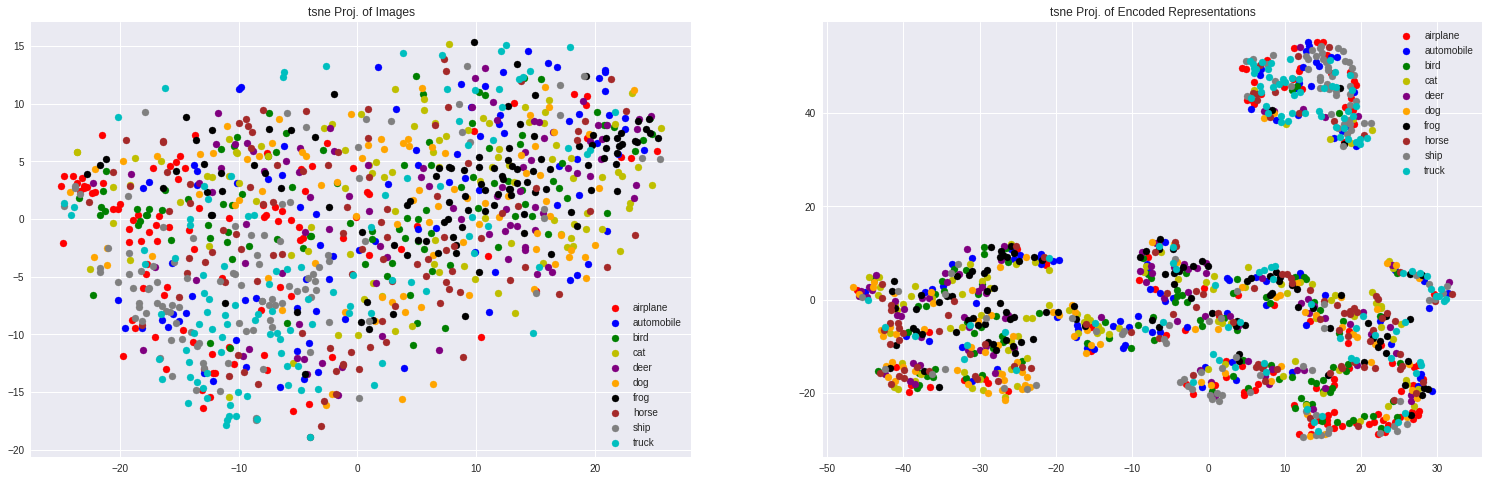

In [84]:
display_model('tsne', imgs_flat, latents, labels, perplexity=30.0)

In t-SNE with perplexity 30, we can see similar patterns.

In the images space, the classes are in one cluster and seem to be all mixed together.

Tough, here we also see, that airplanes, ships and trucks seem to be close together and frogs, cats and deers seem to be somewhat close together.

In the t-SNE plot of the encoded representations, we again see two main clusters, where again, one is mixed up and the other one contains primarily airplanes automobiles trucks and ships.

## Interpolation

In [90]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE, 3))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(3,32,32).permute(1,2,0)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange])
    plt.axis("off")


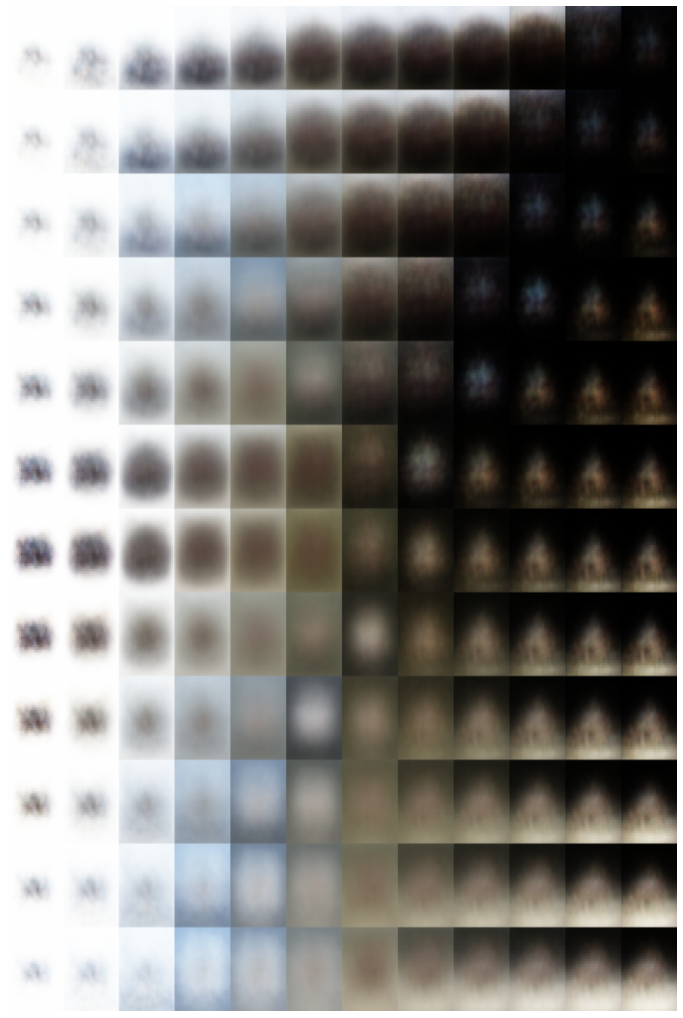

In [93]:
plot_reconstructed(vanilla_vae, xrange=(-3, 3), yrange=(-2, 2), N=12)

The interpolation shows that the level of light is somehow embedded in the encoding and also the center of the image is always in a different color than the surounding area.

This could be due to the fact that normally, the center is in the foreground and in the background we have some other colors.

## clustering and classification

In [95]:
kmeans_imgs = KMeans(n_clusters=10, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=10, random_state=0).fit(latents)

In [96]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [97]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=4.32%
Clustering latents achieves ARI=3.48%


Using both the original images and the latent space achives a bad rand-score.

The adjusted rand-score of the original images is better than the one of the latent space.

In [98]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 2/3072  = 0.07%


The compression ratio is low, because we use a bottleneck of only size 2.

# Convolutional Variational Autoencoder

In [99]:
class Decoder(nn.Module):
    def __init__(self, vae):
        """ Defining decoder """
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(vae.bottleneck, vae.last_size),
                                vae.activation)
        self.trans_convs = []
        self.last_shape = vae.last_shape

        # adding transposedConv+act for each layer
        for i in range(1, len(vae.kernel_sizes) + 1):
            self.trans_convs.append( nn.ConvTranspose2d(in_channels=vae.channels[-i], 
                                              out_channels=vae.channels[-i-1],
                                              kernel_size=vae.kernel_sizes[-i]) )
            self.trans_convs.append( vae.activation )

        self.trans_convs = self.trans_convs[:-1] + [nn.Sigmoid()]   
        self.trans_convs = nn.Sequential(*self.trans_convs)
        return

    def forward(self, x):
        b_size = len(x)

        output = self.fc(x)

        new_shape=(b_size,)+self.last_shape
        output = torch.reshape(output, new_shape)

        output = self.trans_convs(output)
        return output

In [100]:
class ConvVAE(nn.Module):
    """
    Implementation of a convolutional variational autoencoder for 
    CIFAR-10 images
    """
    
    def __init__(self, in_size=(32,32), channels=[3, 32, 16, 16], kernel_sizes=[5,7,5], 
                 bottleneck=2, act="ReLU"):
        """ Model initializer 
        Here, in_size refers to the size of the images without the color channels, the
        number of color channels should be given as channels[0] ."""
        super().__init__()
        assert len(channels)-1 == len(kernel_sizes)
        
        self.in_size = in_size
        self.kernel_sizes = kernel_sizes
        self.channels = channels
        self.bottleneck=bottleneck
        self.activation = get_act(act) 
        kernel_reduction = np.sum(kernel_sizes)-len(kernel_sizes)
        self.last_shape = (channels[-1], (in_size[0]-kernel_reduction), 
                           (in_size[1]-kernel_reduction))
                           
        self.last_size = np.prod(self.last_shape)
        
        self.encoder = self._make_encoder()
        self.decoder = Decoder(self)
        
        self.fc_mu = nn.Linear(self.last_size, bottleneck)
        self.fc_sigma = nn.Linear(self.last_size, bottleneck)
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = []
        
        # adding conv+act for each layer
        for i in range(len(self.kernel_sizes)):
            #layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append(nn.Conv2d(in_channels=self.channels[i], out_channels=self.channels[i+1],
                                   kernel_size=self.kernel_sizes[i]))
            layers.append( self.activation )
            
        layers.append(nn.Flatten())
        
        encoder = nn.Sequential(*layers)
        return encoder
    
    
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        
        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, self.channels[0], *self.in_size)
        
        return x_hat, (z, mu, log_var)

## Training

In [101]:
conv_vae = ConvVAE(channels=[3,64,64,16,16], kernel_sizes=[5,7,7,7])
conv_vae = conv_vae.to(device)

In [102]:
# count_model_params(ae)
print(f"Encoder has {count_model_params(conv_vae.encoder)} params")
print(f"Decoder has {count_model_params(conv_vae.decoder)} params")

Encoder has 268384 params
Decoder has 273171 params


In [103]:
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)


In [40]:
%%time
train_loss, val_loss, loss_iters = train_model(
        model=conv_vae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20, 
        savepath='imgs/conv_vae', model_path='models/conv_vae.pt'
    )

Epoch 0
    Train loss: 2141.20384
    Valid loss: 2127.4265
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
    Train loss: 1970.68564
    Valid loss: 1979.66311
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
    Train loss: 1962.42338
    Valid loss: 1964.79508
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
    Train loss: 1960.76821
    Valid loss: 1970.10734
Epoch 16
Epoch 17
Epoch 18
Epoch 19
    Train loss: 1959.29803
    Valid loss: 1961.37595
Training completed
CPU times: user 5min 56s, sys: 1.66 s, total: 5min 58s
Wall time: 6min


In [104]:
conv_vae, train_loss, val_loss, loss_iters = load_model('models/conv_vae.pt')

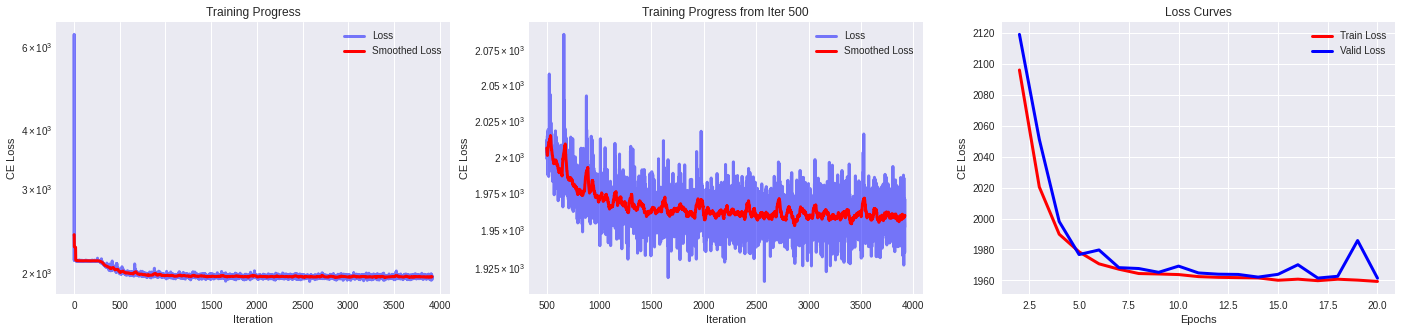

In [105]:
plot_stats_path('models/conv_vae.pt')

We see that in the first 7 epochs, the loss drops significantly, after that, the learning curve flattens.

Generally, the training loss seems to be a good predictor of the validation loss in this case.

## Some Analysis

In [110]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [107]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = conv_vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

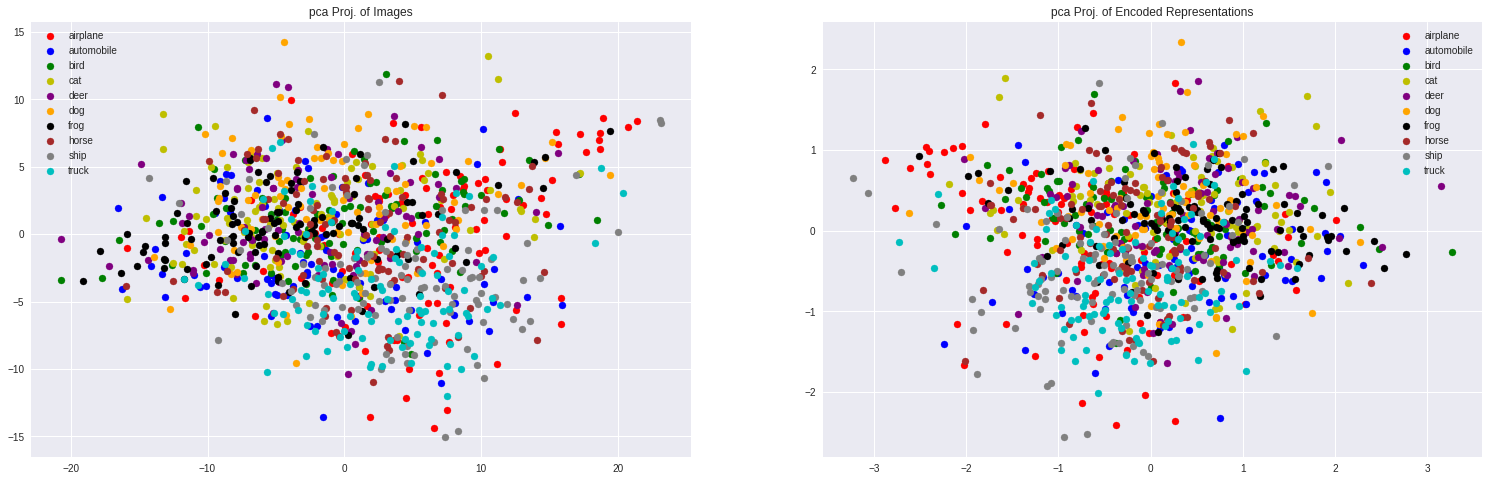

In [108]:
display_model('pca', imgs_flat, latents, labels)

Here the pca projections of the images and the encoded images look very similar. In both we have one cluster which is rather mixed up with different classes.

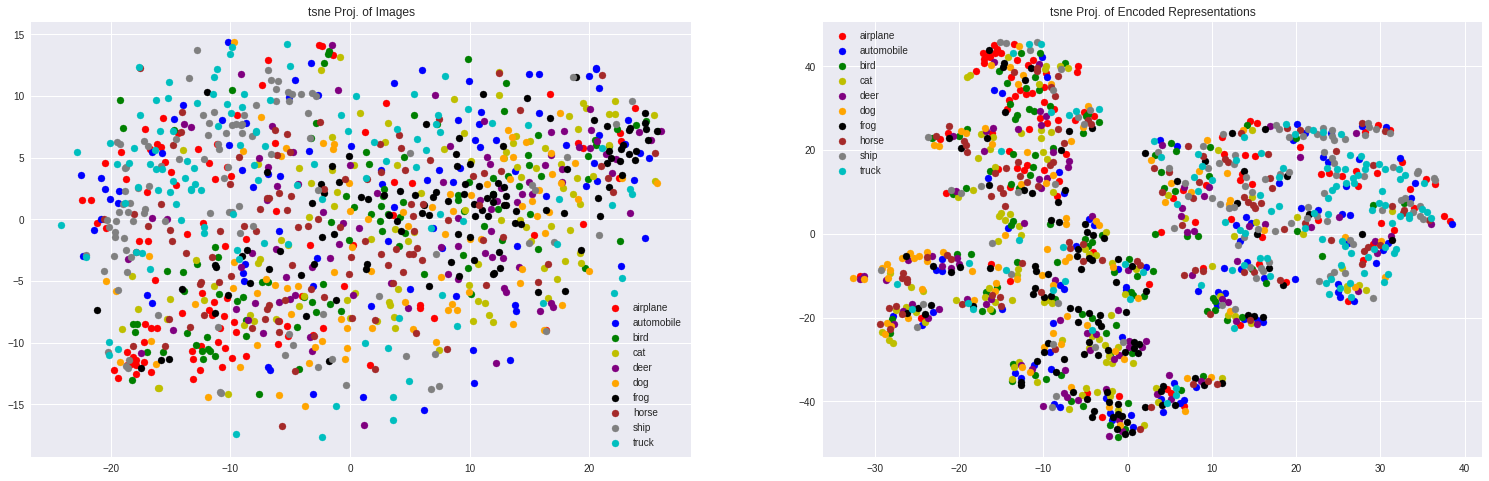

In [109]:
display_model('tsne', imgs_flat, latents, labels, N=1000)

The t-SNE of the images looks similar like in the case of the vanilla variational autoencoder.
The differences arise due to the random initialization of the t-SNE algorithm.

In the t-SNE plot of the encoded representations, several clusters emerge.
Especially trucks and ships cluster together (though there are also many other points in their cluster)

Further, frogs and deers appear in the same areas of the plot.

## Interpolation

In [111]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE, 3))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(3,32,32).permute(1,2,0)
            #x_hat = train_dataset[j+N*i][0].permute(1,2,0)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid)#, extent=[*yrange, *xrange])
    plt.axis("off")


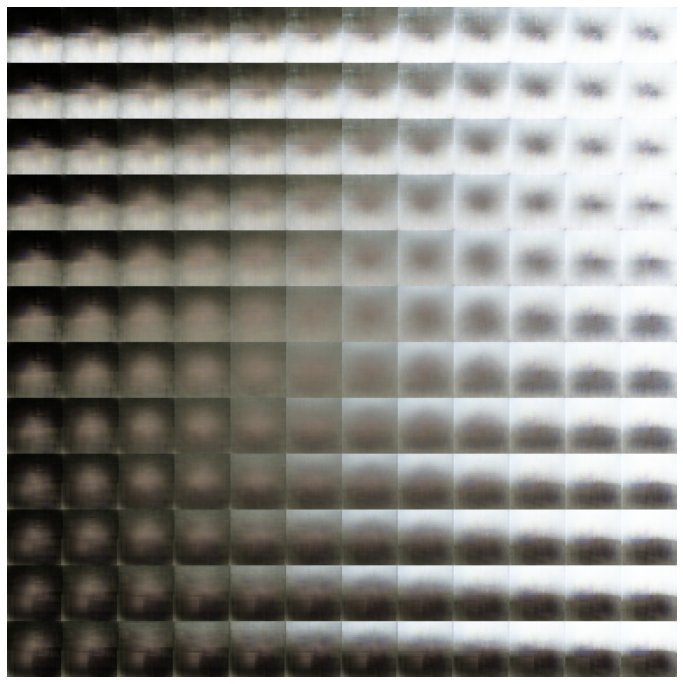

In [112]:
plot_reconstructed(conv_vae, xrange=(-3, 3), yrange=(-3, 3), N=12)

The plot looks like a piece of modern art.

We can see that again, the level of brightness seems to be encoded.

Also some interpolations are brighter in the lower area of the image and some in the upper area.
This could be the embedding of a horizon.

We can also see that the center of the interpolations usually look different than the surroundings.
This again could indicate fore- and background.

## clustering and classification

In [49]:
imgs_flat[0].shape

(3072,)

In [113]:
kmeans_imgs = KMeans(n_clusters=10, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=10, random_state=0).fit(latents)

In [114]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [115]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=4.32%
Clustering latents achieves ARI=2.92%


Here we see that the k-means performs even worse on the latent space of the convolutional VAE than on the vanilla VAE (there it had a ARI of 3.48%).

In [116]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 2/3072  = 0.07%


Again, the compression ratio is low because we only use a size of 2 for our bottleneck.

# Conclusions

| | Fully-Connected VAE | Convolutional VAE |
--- | --- | ---
|training time| 2min 12s | 5min 56s |
ARI kmeans | 3.48% | 2.92%



Generally, we were rather disappointed with the results of our models.

The ARI in both cases is bad. Also the training time for the ConvVAE was significantly larger than for the fully-connected VAE, but we gained nothing from that.

In our opinion, the reason for the bad performance is that CIFAR-10 probably is a hard dataset to encode with a two dimensional probability distribution.
So maybe the bottleneck we used was too small.